In [1]:
from etc.init import *
import etc.figureslib as lib

import NotebookScripter
from NotebookScripter import run_notebook, receive_parameter
NotebookScripter.set_notebook_option(with_matplotlib_backend=None)
savefig = receive_parameter(savefig=False)
saveext = receive_parameter(saveext='pdf')
try:
    data
except NameError:
    data = receive_parameter(data=None)

mplconfig = run_notebook("Figures_matplotlib_config.ipynb")
inject_vars(mplconfig, globals())
if data is None:
    data = run_notebook("Figures_load_data.ipynb")
records = data.records

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
[monochrome_palette]: value was greater than 1 and was clipped.



import copy
import os.path
import itertools
from collections import Iterable, OrderedDict, namedtuple, deque
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image
from matplotlib.gridspec import GridSpec
import pymc3 as pymc
import pandas as pd
from pandas import DataFrame
from parameters import ParameterSet

from importlib import reload

import theano_shim as shim

import mackelab as ml
import mackelab.smttk as smttk
import mackelab.iotools
import mackelab.pymc3
import mackelab.parameters
import mackelab.plot
ml.parameters.Transform.namespaces['shim'] = shim

import sinn
import sinn.histories as histories
import sinn.models
from sinn.optimize.gradient_descent import FitCollection
import sinn.analyze as anlz
from sinn.analyze.axisdata import LogLikelihood, Likelihood, Probability
from sinn.analyze.axis import Axis

import fsGIF.core as core
import fsGIF.fsgif_model as fsgif_model
from fsGIF.fsgif_model

In [2]:
outputname = "Fig2.pdf"

In [3]:
result_seeds = np.arange(300,400)
truemicro_seeds = np.arange(1300,1400)
truemeso_seeds = np.arange(2300,2400)
use_expected_activity = False
num_ref_records = 50

In [4]:
fitrecords = lib.RecordSet('20180827-100303', nodill=False, nodups=False)
fitcoll = FitCollection()
fitcoll.load(fitrecords.extract("parameters", "outputpath"))

In [5]:
modelparams = ml.parameters.params_to_arrays(fitcoll.reffit.parameters.posterior.model.params)
#def draw_target(target):
#    ax.axhline(target, color=black, zorder=-2, linewidth=2)

In [6]:
p = fitcoll.reffit.parameters.posterior.input
Ihist = ml.iotools.load(core.get_pathname(core.data_dir, p.params,
                                          p.name, p.dir))

    p = fitcoll.reffit.parameters.posterior.data
    Ahist = ml.iotools.load(core.get_pathname(core.data_dir, p.params,
                                              p.name, p.dir))

In [7]:
p = fitcoll.reffit.parameters.posterior.data
shist = ml.iotools.load(core.get_pathname(core.data_dir, p.params,
                                          suffix=None, subdir=p.dir))

In [8]:
p = fitcoll.reffit.parameters.posterior.data
ahist = ml.iotools.load(core.get_pathname(core.data_dir, p.params,
                                          'expected_activity', p.dir))

    p = fitcoll.reffit.parameters.posterior.data
    Ahist = ml.iotools.load(core.get_pathname(core.data_dir, p.params,
                                              'activity', p.dir))

In [9]:
def tqdm(x):
    return x
dt=0.010

In [10]:
# res
costtype = fitcoll.reffit.parameters.sgd.cost
result_pset = core.get_result_pset(fitcoll, input_params="brown-noise-input-2pop.params")
#result_pset.seed += 1  # Ensure seed is different for res, truemicro & truemeso
res_stats = lib.TracePDF(dt=dt)
for seed in tqdm(result_seeds):
    result_pset.seed = seed
    if use_expected_activity:
        nbar = core.get_param_sim(result_pset, 'nbar',
                                  desc="{}-activity_all-params_{}-fits_brown-noise_seed-{}"
                                        .format(costtype, len(fitcoll.fits), result_pset.seed))
        if nbar is not None: trace = nbar / modelparams.N / nbar.dt
    else:
        trace = core.get_param_sim(result_pset, '',
                                   desc="{}-activity_all-params_{}-fits_brown-noise_seed-{}"
                                        .format(costtype, len(fitcoll.fits), result_pset.seed))
    res_stats.add_trace(trace)

In [46]:
T = len(res_stats.traces[0])

In [31]:
L = int(len(truemicro_seeds)/2)
ref_seeds = truemicro_seeds[:L]
truetest_seeds = truemicro_seeds[L:]

In [72]:
# truemicro
from zipfile import BadZipfile
p = copy.deepcopy(fitcoll.reffit.parameters.posterior.data)
p._url = None  # Not copied with deep copy; needed for `save`
p.params = core.get_pset(fitcoll.reffit, p.params.model, input_params="brown-noise-input-2pop.params")
p.params.dt = 0.0002
if use_expected_activity:
    suffix = 'expected_activity'
else:
    suffix = 'activity'
ref_stats = lib.TracePDF(dt=dt, timelim=(0, 19.99))
truetest_stats = lib.TracePDF(dt=dt, timelim=(0, 19.99))
#p.params.seed = result_pset.seed - 1   # Ensure we have different seed than result sim
for seed in tqdm(ref_seeds):
    p.params.seed = seed
    try:
        trace = ml.iotools.load(core.get_pathname(core.data_dir, p.params,
                                                  suffix, p.dir))
        ref_stats.add_trace(trace)
    except (EOFError, OSError, BadZipfile):
        pass
for seed in tqdm(truetest_seeds):
    p.params.seed = seed
    try:
        trace = ml.iotools.load(core.get_pathname(core.data_dir, p.params,
                                                  suffix, p.dir))
        truetest_stats.add_trace(trace)
    except (EOFError, OSError, BadZipfile):
        pass
    
truemicro_stats = ref_stats + truetest_stats

In [12]:
# truemeso
p = core.get_pset(fitcoll.reffit, modelparams, input_params="brown-noise-input-2pop.params")
# Ensure that we have a different seed than for the result sim, otherwise not comparble with micro sim
truemeso_stats = lib.TracePDF(dt=dt)
#p.seed = result_pset.seed + 1
for seed in tqdm(truemeso_seeds):
    p.seed = seed
    if use_expected_activity:
        nbar = core.get_param_sim(p, 'nbar', desc="true-activity_homo_brown-noise_seed-{}".format(p.seed))
        if nbar is not None: trace = nbar / modelparams.N / nbar.dt
    else:
        trace = core.get_param_sim(p, '', desc="true-activity_homo_brown-noise_seed-{}".format(p.seed))
    truemeso_stats.add_trace(trace)

    # Used to generate spike simulation using the test input
    ml.parameters.params_to_lists(p.params).save(
        "/home/alex/Recherche/macke_lab/run/fsGIF/params/result-params/spikes-homo-brown-noise.params",
        expand_urls=True)

In [19]:
p = ParameterSet(core.param_dir + "/brown-noise-input-2pop.params")
testIhist = ml.iotools.load(core.get_pathname(core.data_dir, p, suffix=None, subdir='inputs'))

<Figure size 720x480 with 0 Axes>

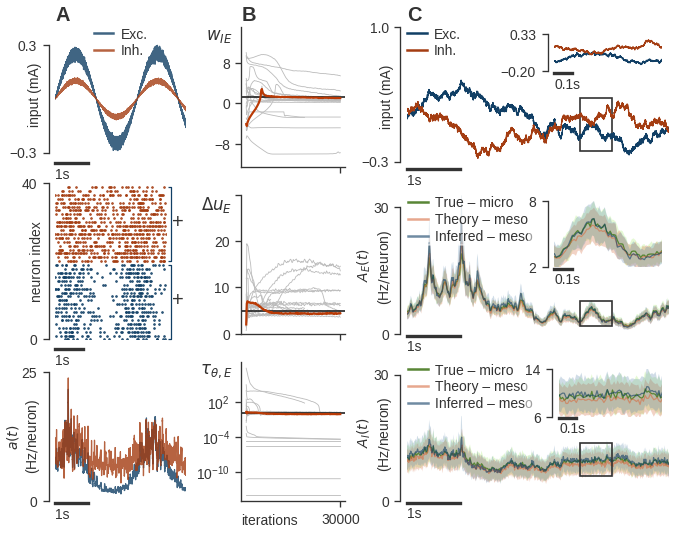

In [26]:
fig = plt.figure()

ml.rcParams['plot.subrefy'] = 1.02

inset = True
#insetxlim = (16.65, 16.95)
insetxlim = (17.3, 17.9)
insetwidth = np.diff(insetxlim)[0]

topmargin = 0.23 # Space for subplot labels
height = 1.2*figheight
topmarginfrac = topmargin / (height + topmargin)
fig = plt.figure(figsize=(textwidth, height + topmargin))
fig.subplots_adjust(top=1-topmarginfrac)

# First column
gsa1 = GridSpec(1,1)
gsa1.update(left=0.08, right=0.27, bottom=0.7, hspace=0.2)

ax = plt.subplot(gsa1[0,0])
lib.plot_series(Ihist, xlim=(10,14), xscalelen=1, ylim=(-.35,.4), ybounds=(-.3, .3),
          ylabel="input (mA)", alpha=0.8)
ml.plot.subreflabel(ax, "a", backgroundcolor=lib.white)

ax.legend(["Exc.", "Inh."], loc='upper center')
ml.plot.set_legend_linewidth(1.5, ax=ax)

gsa2 = GridSpec(1,1) # Use another gridspec to add some right margin
gsa2.update(left=0.08, right=0.24, top=0.66, bottom=0.37)
ax = plt.subplot(gsa2[0,0])
lib.plot_raster(shist, xlim=(10,14), xscalelen=1, xscaleoffset=2, ylabel='neuron index',
            markersize=0.3)
    # Draw brackets grouping populations
x = 14.1; w = .1; s = 20  # s : number of neurons per pop
groups = mpl.collections.LineCollection(
    [ [(x, i*s), (x+w, i*s), (x+w, (i+1)*s-1), (x, (i+1)*s-1)]
      for i in range(shist.npops) ])
groups.set_clip_on(False)  # Allows drawing outside the data window
ax.add_collection(groups)
for i in range(shist.npops):
    ax.text(x+1.5*w, (i+.5)*s, "+", ha='left', va='center', fontdict={'fontsize': 'large'})

gsa3 = GridSpec(1,1)
gsa3.update(left=0.08, right=.27, top=0.31, bottom=0.07)
ax = plt.subplot(gsa3[0,0])
lib.plot_series(ahist, xlim=(10,14), xscalelen=1, ylim=(0,25), ylabel="$a(t)$\n(Hz$/$neuron)",
          alpha=0.8, color=lib.colours)

    
# Second column
gsb = GridSpec(3,1)
gsb.update(left=0.35, right=0.5, bottom=0.07, hspace=0.2)

vars = ['w', 'Δu', 'τ_θ']
labels = ['$w_{IE}$', '$\\Delta u_E$', '$\\tau_{\\theta,E}$']
idcs = [2, 0, 0]
yticks = [(-8, 0, 8),
          (0, 10, 20, 30),
          (1e-10, 1e-4, 1e2)]
ylims = [(-12.5, 15),
         (0, 20),
         None]
scales = ['linear', 'linear', 'log']
for k, (var, lbl, idx, ytick, ylim, scale) in enumerate(
      zip(vars, labels, idcs, yticks, ylims, scales)):
    ax = plt.subplot(gsb[k,0])
    fitcoll.plot(var, idx=idx, ax=ax, ylabel=lbl, yticks=ytick,
                 ylim=ylim, yscale=scale, keep_range=1,
                 target=modelparams)
    if k < 2:
        ax.set_xticklabels([""])
    if k == 0:
        ml.plot.subreflabel(ax, "b", backgroundcolor=lib.white, zorder=2)
    if k == 2:
        ax.set_xlabel("iterations", ha='left')
        ax.xaxis.set_label_coords(0, -.09)

# Third column
gsc = GridSpec(3,1)
gsc.update(left=0.59, right=.97, bottom=0.07, hspace=0.2)

ax = plt.subplot(gsc[0,0])
insetylim = (-0.2, 0.33)
insetheight = np.diff(insetylim)[0]
lib.plot_series(testIhist, xlim=(14, 19), xscalelen=1, xscaleoffset=0, ylim=(-.35,1), ybounds=(-.3, 1),
                ylabel=("input (mA)"), ylabelshift=.25)
ax.legend(["Exc.", "Inh."], loc='upper left', bbox_to_anchor=(0, 1))
ml.plot.set_legend_linewidth(1.5, ax=ax)
ml.plot.subreflabel(ax, "c", backgroundcolor=None)

#ax = plt.subplot(nrows,ncols,4+2*ncols)
if inset:
    axins = inset_axes(ax, width=.9, height=.31, loc='upper right')
    lib.plot_series(testIhist, ax=axins, xlim=insetxlim, xscalelen=.1,
                    ylim=insetylim, ybounds=insetylim)
    rect = mpl.patches.Rectangle((insetxlim[0], insetylim[0]), insetwidth, insetylim[1]-insetylim[0]-insetheight*0.03, ec=lib.black, fc=None)
    ax.add_patch(rect)

ax = plt.subplot(gsc[1,0])
ylim=(0,33)
insetylim = (2,8)
insetheight = np.diff(insetylim)[0]
ylabel="$A_E(t)$ \n(Hz$/$neuron)  "
lib.plot_series_stats(truemicro_stats, xlim=(14, 19), xscalelen=1, ylim=ylim, ybounds=(0, 30),
                idx=0, linecolor=tmicroc[0], shadecolor=tmicrocshade[0],
                alpha=tmicroα, zorder=tmicroz, ylabel=ylabel,
                label='True – micro')
lib.plot_series_stats(truemeso_stats, xlim=(14, 19), xscalelen=1, ylim=ylim, ybounds=(0, 30),
                idx=0, linecolor=tmesoc[0], shadecolor=tmesoc[0],
                alpha=tmesoα, zorder=tmesoz, ylabel=ylabel, ylabelshift=.25,
                label='Theory – meso')
lib.plot_series_stats(res_stats, xlim=(14, 19), xscalelen=1, ylim=ylim, ybounds=(0, 30),
                idx=0, linecolor=imesoc[0], shadecolor=imesocshade[0],
                zorder=imesoz, alpha=imesoα, ylabel=ylabel, ylabelshift=.25,
                label='Inferred – meso')

#ax = plt.subplot(nrows,ncols,4)
if inset:
    axins = inset_axes(ax, width=.9, height=.55, loc='upper right', axes_kwargs={'zorder':2})
    lib.plot_series_stats(truemicro_stats, ax=axins, xlim=insetxlim, xscalelen=.1, ylim=insetylim,
                  idx=0, linecolor=tmicroc[0], shadecolor=tmicrocshade[0],
                  zorder=tmicroz, alpha=tmicroα, maxstops=8000)
    lib.plot_series_stats(truemeso_stats, ax=axins, xlim=insetxlim, xscalelen=.1, ylim=insetylim,
                  idx=0, linecolor=tmesoc[0], shadecolor=tmesoc[0],
                  zorder=tmesoz, alpha=tmesoα, maxstops=8000)
    lib.plot_series_stats(res_stats, xlim=insetxlim, xscalelen=.1, ylim=insetylim,
                  idx=0, linecolor=imesoc[0], shadecolor=imesocshade[0],
                  alpha=imesoα, zorder=imesoz, maxstops=8000)
    lib.set_full_axes_background(axins, '#FFFFFF88', zorder=1)
    rect = mpl.patches.Rectangle((insetxlim[0], insetylim[0]), insetwidth, insetylim[1]-insetylim[0]-insetheight*0.03, ec=lib.black, fc=None)
    ax.add_patch(rect)

ax.legend(loc='upper left', bbox_to_anchor=(0, 1), framealpha=.5, borderpad=0.1)
ml.plot.set_legend_linewidth(1.5, ax=ax)

ax = plt.subplot(gsc[2,0])
ylim=(0,33)
ybounds=(0,30)
insetylim = (6,14)
insetheight = np.diff(insetylim)[0]
ylabel="$A_I(t)$ \n(Hz$/$neuron)  "
lib.plot_series_stats(truemicro_stats, xlim=(14, 19), xscalelen=1, xscaleoffset=1, ylim=ylim, ybounds=ybounds,
              idx=1, linecolor=tmicroc[1], shadecolor=tmicrocshade[1],
              zorder=tmicroz, alpha=tmicroα, ylabel=ylabel, ylabelshift=.25,
              label="True – micro")
lib.plot_series_stats(truemeso_stats, xlim=(14, 19), xscalelen=1, xscaleoffset=1, ylim=ylim, ybounds=ybounds,
              idx=1, linecolor=tmesoc[1], shadecolor=tmesoc[1],
              zorder=tmesoz, alpha=tmesoα, ylabel=ylabel, ylabelshift=.25,
              label="Theory – meso")
lib.plot_series_stats(res_stats, xlim=(14, 19), xscalelen=1, ylim=ylim, ybounds=ybounds, ylabelshift=.25,
              idx=1, linecolor=imesoc[1], shadecolor=imesocshade[1],
              alpha=imesoα, zorder=imesoz, ylabel=ylabel,
              label="Inferred – meso")

#ax = plt.subplot(nrows,ncols,4+ncols)
if inset:
    axins = inset_axes(ax, width=.86, height=.4, loc='upper right', axes_kwargs={'zorder':2})
    lib.plot_series_stats(truemicro_stats, xlim=insetxlim, xscalelen=.1, ylim=insetylim,
                  idx=1, linecolor=tmicroc[1], shadecolor=tmicrocshade[1],
                  zorder=tmicroz, alpha=tmicroα, maxstops=8000)
    lib.plot_series_stats(truemeso_stats, xlim=insetxlim, xscalelen=.1, ylim=insetylim,
                  idx=1, linecolor=tmesoc[1], shadecolor=tmesoc[1],
                  zorder=tmesoz, alpha=tmesoα, maxstops=8000)
    lib.plot_series_stats(res_stats, xlim=insetxlim, xscalelen=.1, ylim=insetylim,
                  idx=1, linecolor=imesoc[1], shadecolor=imesocshade[1],
                  alpha=imesoα, zorder=imesoz, maxstops=8000)
    lib.set_full_axes_background(axins, '#FFFFFF88', zorder=1)
    rect = mpl.patches.Rectangle((insetxlim[0], insetylim[0]), insetwidth, insetylim[1]-insetylim[0]-insetheight*0.03, ec=lib.black, fc=None)
    ax.add_patch(rect)

ax.legend(loc='upper left', bbox_to_anchor=(0, 1), framealpha=.5, borderpad=0.1)
ml.plot.set_legend_linewidth(1.5, ax=ax)

assert(outputname == "Fig2.pdf")
if savefig:
    plt.savefig("figures/" + os.path.splitext(outputname)[0] + '.' + saveext.strip('.'), transparent=True, bbox_inches=None)
    #plt.savefig("Fig2_candidate.pdf", transparent=True, bbox_inches=None)

ml.rcParams['plot.subrefy'] = 1.  # Reset to its default value

In [23]:
mpl.rcParams['figure.dpi'] = 120

Sine (training) input parameters

OU (test) input parameters

In [17]:
ParameterSet(core.param_dir + "/brown-noise-input-2pop.params")

{'t0': 0,
 'tn': 20,
 'dt': 0.0002,
 'seed': 315,
 'eval': 'I',
 'inputs': ['I'],
 'I': {'model': 'DriftDiffusion',
  'params': {},
  'shape': (2,),
  'init_cond': {'x': [0.1, 0.05]},
  'namespace': {'μ': [0.1, 0.05], 'τ': 1, 'q': [0.125, 0.125]},
  'drift': '(μ-x[t-1])/τ',
  'diffusion': 'np.sqrt(2/τ) * q'}}

In [75]:
barstats = lib.BarStats(reftraces=ref_stats.traces,
                        true=truetest_stats.traces,
                        truemeso=truemeso_stats.traces,
                        mapmeso=res_stats.traces)

In [83]:
models=['true', 'truemeso', 'mapmeso']

In [78]:
ρbar = {model: np.mean(_ρ) for model,_ρ in barstats.ρ.items()}
rmsebar = {model: np.mean(_r) for model,_r in barstats.rmse.items()}

In [84]:
ρ = {}
rmse = {}
for model,traces in [('true', truetest_stats.traces),
                    ('truemeso', truemeso_stats.traces),
                    ('mapmeso', res_stats.traces)]:
    rmse[model] = lib.trace_rms(traces, ref_stats.traces).mean(axis=0)
    ρ[model]    = lib.trace_corr(traces, ref_stats.traces).mean(axis=0)

In [91]:
measures = pd.DataFrame({r'$\bar{ρ}$': ρbar,
                      'ρ': ρ,
                      r'$\overline{RMSE}$': rmsebar,
                      'RMSE':rmse})
measures

,$\bar{ρ}$,ρ,$\overline{RMSE}$,RMSE
mapmeso,0.918192,"[0.44262748275250197, 0.01899644022179659]",0.895269,"[3.550214376783371, 0.09236421588496552]"
true,0.949869,"[0.44351333811879157, 0.017758278424423728]",0.488930,"[3.417673669591242, 0.0744980530999218]"
truemeso,0.945691,"[0.44225209817215805, 0.01827251124547458]",0.693530,"[3.4062270632982257, 0.08166392028883526]"


### Log likelihood of different models

In [18]:
def logL(a, A, N, dt):
    """
    a: expected activity computed for a given model
    A: data
    """
    n = A*N*dt
    p = sinn.clip_probabilities(a*dt)
    return ( -shim.gammaln(n+1) - shim.gammaln(N-n+1)
             + n*shim.log(p)
             + (N-n)*shim.log(1-p)
            ).sum()

In [19]:
N = np.array(fitcoll.parameters.posterior.model.params.N)
dt = 0.001

We don't load the expected activity, so don't compute by default

    a = anlz.subsample(ahist, target_dt=dt)[10.:19.]
    A = anlz.subsample(Ahist, target_dt=dt)[10.:19.]

    logL(a, A, N, dt)

In [20]:
Ipset = fitcoll.reffit.parameters.posterior.input
result_pset = core.get_result_pset(fitcoll, input_params=Ipset)
nbar = core.get_param_sim(result_pset, 'nbar',
                          desc="activity_all-params_{}-fits_training-input"
                                .format(len(fitcoll.fits)))
if nbar is not None: res = nbar / modelparams.N / nbar.dt

In [21]:
atrain = anlz.subsample(res, target_dt=dt)[10.:19.]
#A = anlz.subsample(Ahist, target_dt=dt)[10.:19.]

    logL(atrain, A, N, dt)

## Ultimate fit values

In [8]:
sorted([fit.data.result_cost.logL for fit in fitcoll.finite_fits])[::-1]

[-23747336.0,
 -23747340.0,
 -23747346.0,
 -23747366.0,
 -23747368.0,
 -23747376.0,
 -23747428.0,
 -23747490.0,
 -23747546.0,
 -23747548.0,
 -23747632.0,
 -23747660.0,
 -23747660.0,
 -23747662.0,
 -23747676.0,
 -23747820.0,
 -23747900.0,
 -23805506.0,
 -23813990.0,
 -23824228.0,
 -23883728.0]

## **Note** Loglikelihood values are discretized.
If we set some threshold to keep only the largest $log L$ values from the optimization, we find 1023 values but only 23 unique.

In [63]:
cost_traces = np.array(list(itertools.chain.from_iterable((fit.data.cost_trace[fit.data.cost_trace.logL>-23747376.0].logL for fit in fitcoll.finite_fits))))
len(cost_traces), len(np.unique(cost_traces))

(1023, 23)

They all corresponds to jumps of two in the likelihood. Moreover, whereas our "optimum" had $log L$ = -23747336, a few traces found even better parameter sets (they just didn't terminate with them)

In [64]:
sorted(np.unique(cost_traces))[::-1]

[-23747330.0,
 -23747332.0,
 -23747334.0,
 -23747336.0,
 -23747338.0,
 -23747340.0,
 -23747342.0,
 -23747344.0,
 -23747346.0,
 -23747348.0,
 -23747350.0,
 -23747352.0,
 -23747354.0,
 -23747356.0,
 -23747358.0,
 -23747360.0,
 -23747362.0,
 -23747364.0,
 -23747366.0,
 -23747368.0,
 -23747370.0,
 -23747372.0,
 -23747374.0]

This is due to the single-precision float used to store the likelihood:

In [60]:
np.float32(-23747331.0)

-23747332.0

In [67]:
sum(cost_traces==-23747334.0)

15

There are in fact 4 fits which found parameter values with $logL$ equal to the "optimum".

In [10]:
len([fit for fit in fitcoll.finite_fits if any(-23747336.0 <= fit.data.cost_trace.logL)])

4